In [38]:
# set parameters
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:,.2f}'.format

METADATA = {'Contributor': 'T. Dunn', 'Date': '2021-12-27'}
FSIZE = [5,4]
FDPI = 100
SAVEFIGS = False
SAVETABS = False

In [39]:
ALL_BOOKS = ['BR','PH','MM','HotDQ','RoT','DMG','PotA','OotA','SCAG','CoS','SKT','VGtM','TftYP','ToA','XGtE','MToF','WDH','WDotMM','GGtR','GoS','BGDiA','ERftLW','EGtW','MOoT','IDRotF','TCoE','CM','VRGtR','WBtW','FToD','SaCoC']
ALL_SOURCE_BOOKS = ['BR','PH','MM','DMG','SCAG','VGtM','XGtE','MToF','GGtR','ERftLW','EGtW','MOoT','TCoE','VRGtR','FToD','SaCoC']
ALL_ADVENTURE_BOOKS = ['HotDQ','RoT','PotA','OotA','CoS','SKT','TftYP','ToA','WDH','WDotMM','GoS','BGDiA','IDRotF','CM','WBtW']

dfB = pd.DataFrame({
    'Book':  ['PH','HotDQ','MM','RoT','DMG','PotA','OotA','SCAG','CoS','SKT','VGtM','TftYP','ToA','XGtE','MToF','WDH','BR','WDotMM','GGtR','GoS','BGDiA','ERftLW','EGtW','MOoT','IDRotF','TCoE','CM','VRGtR','WBtW','FToD','SaCoC'],
    'Year':  [2014, 2014, 2014, 2014, 2014, 2015, 2015, 2015, 2016, 2016, 2016, 2017, 2017, 2017, 2018, 2018, 2018, 2018, 2018, 2019, 2019, 2019, 2020, 2020, 2020, 2020, 2021, 2021, 2021, 2021, 2021], 
    'Month': [   8,    8,    9,   11,   12,    4,    9,   11,    3,    9,   11,    4,    9,   11,    5,    9,   11,  11,   11,    5,    9,   11,    3,    7,    9,   11,    3,    5,    9,   10,   12], 
    'Day':   [  19,   19,    7,    4,    9,    7,   15,    3,   16,    6,   15,    4,   19,   12,   29,   18,   19,  20,   20,   21,   17,   19,    7,   21,   15,   17,   16,   18,   21,   26,    7]
})
dfB['Type'] = dfB.apply(lambda row: ('Source' if (row['Book'] in ALL_SOURCE_BOOKS) else 'Adventure'), axis=1)
dfB['Date'] = pd.to_datetime(dfB[['Year', 'Month', 'Day']])
dfB = dfB.sort_values(by=['Date'])
dfB = dfB.set_index('Book')

In [40]:
# define functions
def find_nearest_loc(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def find_nearest_CR(CRs, array, value):
    idx = find_nearest_loc(array, value)
    CRs = np.asarray(CRs)
    return CRs[idx]

def effective_DPR_exp(DPR, AB):
    return np.power(0.6,  0.5)*DPR*np.power(1 + 0.05/0.6, AB - 3)

def effective_HP_exp(HP, AC):
    return np.power(0.6, -0.5)*HP*np.power(1 + 0.05/0.6, AC - 13)

def effective_XP_exp(HP, AC, DPR, AB):
    return 0.25*HP*DPR*np.power(1 + 0.05/0.6, AC + AB - 16)

def effective_DPR_linear(DPR, AB):
    return np.power(0.6,  0.5)*DPR*(1 + (0.05/0.6)*(AB - 3))

def effective_HP_linear(HP, AC):
    return np.power(0.6, -0.5)*HP*(1 + (0.05/0.6)*(AC - 13))

def effective_XP_linear(HP, AC, DPR, AB):
    return 0.25*HP*DPR*(1 + (0.05/0.6)*(AC + AB - 16))
    
def defensive_CR(df, HP, AC):
    n = df.shape[0]
    id = find_nearest_loc(df['HP Mean'], HP)
    CR_t = df.index[id]
    AC_t = df['AC'].loc[CR_t]
    id = int(max(0, min(n - 1, id + np.fix(0.5*(AC - AC_t)))))
    CR = df.index[id]
    return CR

def offensive_CR(df, DPR, AB):
    n = df.shape[0]
    id = find_nearest_loc(df['DPR Mean'], DPR)
    CR_t = df.index[id]
    AB_t = df['AB'].loc[CR_t]
    id = int(max(0, min(n - 1, id + np.fix(0.5*(AB - AB_t)))))
    CR = df.index[id]
    return CR
    
def rsquared(y, yf):
    y = np.asarray(y)
    yf = np.asarray(yf)
    ybar = np.mean(y)
    SStot = np.sum(np.power(np.subtract(y, ybar), 2))
    SSres = np.sum(np.power(y - yf, 2))
    return 1 - SSres/SStot

In [41]:
from scipy.interpolate import interp1d

# import data
dfD = pd.read_csv('dmg-targets-cr-and-xp.csv') # 'CR','PB','XP','AC','HP Mean','AB','DPR Mean'
dfD['eHP Mean']  = dfD.apply(lambda row: effective_HP_linear(row['HP Mean'], row['AC']), axis=1)
dfD['eDPR Mean'] = dfD.apply(lambda row: effective_DPR_linear(row['DPR Mean'], row['AB']), axis=1)
dfD['eXP Mean'] = dfD.apply(lambda row: effective_XP_linear(row['HP Mean'], row['AC'], row['DPR Mean'], row['AB']), axis=1)
dfD.set_index('CR', inplace=True)

xp2cr  = interp1d(dfD['eXP Mean'], dfD.index, kind='cubic', fill_value=(0.0,30.0), bounds_error=False)
hp2cr  = interp1d(dfD['eHP Mean'], dfD.index, kind='cubic', fill_value=(0.0,30.0), bounds_error=False)
dpr2cr = interp1d(dfD['eDPR Mean'], dfD.index, kind='cubic', fill_value=(0.0,30.0), bounds_error=False)

df0 = pd.read_csv('monster-cr-and-xp.csv')  # 'Monster','Book','Page','Type','Category','Legendary','CR','PB','XP',
                                            # 'HP','AC','adj HP','adj AC',
                                            # 'AB','adj AB','DPR', 'adj DPR'

df0 = df0.astype({'Book': 'category', 'Category': 'category', 'Legendary': 'category', 'Type': 'category'})

df0['eHP']  = df0.apply(lambda row: effective_HP_linear(row['adj HP'], row['adj AC']), axis=1)
df0['eDPR'] = df0.apply(lambda row: effective_DPR_linear(row['adj DPR'], row['adj AB']), axis=1)
df0['eXP']  = df0.apply(lambda row: effective_XP_linear(row['adj HP'], row['adj AC'], row['adj DPR'], row['adj AB']), axis=1)
#df0['eCR']  = df0.apply(lambda row: find_nearest_CR(dfD.index, dfD['eXP Mean'], row['eXP']), axis=1)
df0['D-eCR']  = df0.apply(lambda row: float(hp2cr(row['eHP'])), axis=1)
df0['O-eCR']  = df0.apply(lambda row: float(dpr2cr(row['eDPR'])), axis=1)
df0['eCR']  = df0.apply(lambda row: float(xp2cr(row['eXP'])), axis=1)
df0['eHP Ratio'] = df0.apply(lambda row: row['eHP']/dfD.loc[row['CR'], 'eHP Mean'], axis=1)
df0['eDPR Ratio'] = df0.apply(lambda row: row['eDPR']/dfD.loc[row['CR'], 'eDPR Mean'], axis=1)
df0['eCR Delta'] = df0['eCR'] - df0['CR']
df0['eXP Ratio'] = df0['eXP'] / df0['XP']
df0['eXP Skew'] = (df0['eDPR Ratio'] - df0['eHP Ratio'])/(df0['eDPR Ratio'] + df0['eHP Ratio'])

df0['D-CR DMG'] = df0.apply(lambda row: defensive_CR(dfD, row['adj HP'], row['adj AC']), axis=1)
df0['O-CR DMG'] = df0.apply(lambda row: offensive_CR(dfD, row['adj DPR'], row['adj AB']), axis=1)
df0['C-CR DMG'] = df0.apply(lambda row: find_nearest_CR(dfD.index, dfD.index, 0.5*(row['D-CR DMG'] + row['O-CR DMG'])), axis=1)
df0['C-CR DMG Delta'] = df0['C-CR DMG'] - df0['CR']
df0['XP DMG'] = df0.apply(lambda row: dfD.loc[row['C-CR DMG'], 'XP'], axis=1)
df0['XP DMG Ratio'] = df0['XP DMG'] / df0['XP']
#df0['C-CR DMG'] = 0.5*(df0['D-CR DMG'] + df0['O-CR DMG'])

df0['Date'] = df0.apply(lambda row: dfB.loc[row['Book'], 'Date'], axis=1)
df0['Book Type'] = df0.apply(lambda row: dfB.loc[row['Book'], 'Type'], axis=1)

len(df0.index.tolist())
print('Includes {} monsters in database'.format(len(df0.index.to_list())))

Includes 1435 monsters in database


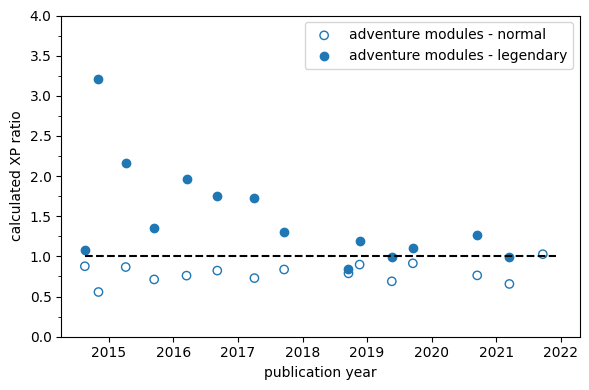

In [42]:
# plot eXP ratio vs time. Split data by book type.
col = 'eXP Ratio'
groupbyCol = 'Date'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
groups = {
    'adventure modules - normal': {
        'Book Type': ['Adventure'],
        'Legendary': ['N'],
        'Edge Color': colors[0],
        'Face Color': 'none',
        'Marker': 'o'
    },
    'adventure modules - legendary': {
        'Book Type': ['Adventure'],
        'Legendary': ['L','LL'],
        'Edge Color': colors[0],
        'Face Color': colors[0],
        'Marker': 'o'
    }
}

# summarize the current dataset
df1 = df0[df0['CR'].between(1,30) & df0['Legendary'].isin(['N','L','LL'])]

# plot results
fig = plt.figure(figsize=[6,4], dpi=FDPI, tight_layout=True)
ax = plt.axes()
dateLims = [df1['Date'].min(),df1['Date'].max()]

for g in groups:
    group = groups[g]
    mask = (df1['Book Type'].isin(group['Book Type']) & df1['Legendary'].isin(group['Legendary']))
    dfG = df1[mask].groupby(['Date']).size().to_frame('Total').reset_index()
    dfG['Mean'] = df1[mask].groupby(['Date']).mean().reset_index()[col]
    dfG['Std Dev'] = df1[mask].groupby(['Date']).std().reset_index()[col]
    dfG = dfG.sort_values(by=['Date'])
    dfG = dfG[dfG['Total'].ge(1)]
    ax.scatter(x='Date', y='Mean', data=dfG, label=g, marker=group['Marker'], 
        edgecolors=group['Edge Color'], facecolors=group['Face Color'])

ax.plot(dateLims, [1]*len(dateLims), '--', color='k')
ax.set(xlabel='publication year', ylabel='calculated XP ratio', ylim=[0,4])
ax.legend()

ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

if SAVEFIGS: plt.savefig('exp-ratio-mean-vs-time-adventure-modules-legendary.svg', metadata=METADATA)

In [43]:
# summary table of legendary monsters from early adventure books
df1 = df0[df0['CR'].between(1,30) & df0['Book Type'].isin(['Adventure']) & df0['Date'].lt('2018-1-1') & df0['Legendary'].isin(['L','LL'])]
df1 = df1.sort_values(by=['Date','Monster'])
dfG = df1[['Date','Book','Monster']]
dfG['Monsters'] = df1.groupby(['Book'])['Monster'].transform(lambda x: ', '.join(x))
dfG = dfG[['Book','Monsters']].drop_duplicates()

if SAVETABS: dfG.to_html('./early-adventure-legendary-monsters.html', index=False, classes='center', float_format='{:,.2f}'.format, border=0)

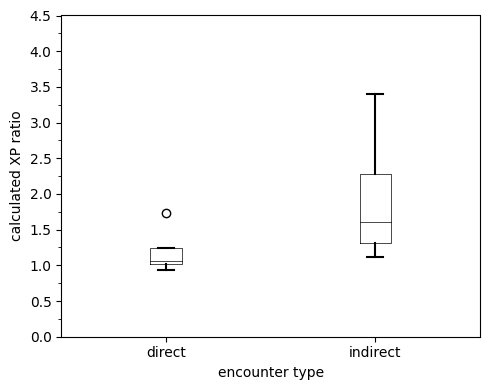

In [44]:
# plot the range of eXP values for legendary monsters encountered directly and indirectly
directMonsters = ['Rezmir','Yestabrod','Tarul Var','Atropal']
df1 = df0[df0['CR'].between(1,30) & df0['Book Type'].isin(['Adventure']) & df0['Date'].lt('2018-1-1') & df0['Legendary'].isin(['L','LL'])]
df1['Encounter Type'] = 'indirect'
df1.loc[df1['Monster'].isin(directMonsters), 'Encounter Type'] = 'direct'
df1.sort_values(by=['Encounter Type','eXP Ratio'], inplace=True)

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(ylabel='calculated XP ratio', xlabel='encounter type', ylim=[0,4.5])
bp = ax.boxplot(tuple(df1[df1['Encounter Type'].isin([x])]['eXP Ratio'] for x in df1['Encounter Type'].unique()), 
    labels=df1['Encounter Type'].unique(), patch_artist=False,
    showmeans=False, vert=True, showfliers=True,
    medianprops={'color': 'k', 'linewidth': 0.5},
    #boxprops={'facecolor': 'C0', 'edgecolor': 'white', 'linewidth': 0.5},
    boxprops={'color': 'k', 'linewidth': 0.5},
    whiskerprops={'color': 'k', 'linewidth': 1.5},
    capprops={'color': 'k', 'linewidth': 1.5})

ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

if SAVEFIGS: plt.savefig('exp-ratio-vs-encounter-type.svg', metadata=METADATA)

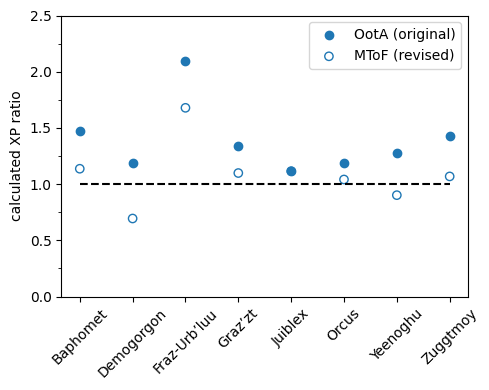

In [45]:
# list of monsters published in two different books
df1 = df0[df0['CR'].between(1,30) & df0['Legendary'].isin(['L','LL'])]
dfG = df1.groupby(['Monster','Book']).size().to_frame('Total').reset_index()
dfG = dfG[dfG['Total'].gt(0)]
dfG = dfG.groupby(['Monster']).size().to_frame('Total').reset_index()
dfG = dfG[dfG['Total'].gt(1)]
dupMonsters = dfG['Monster'].tolist()

df1 = df1[df1['Monster'].isin(dupMonsters)]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# create figure
fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(ylabel='calculated XP ratio', ylim=[0,2.5])

ax.scatter(x='Monster', y='eXP Ratio', data=df1[df1['Book'].isin(['OotA'])], label='OotA (original)', marker='o', edgecolors=colors[0], facecolors=colors[0])
ax.scatter(x='Monster', y='eXP Ratio', data=df1[df1['Book'].isin(['MToF'])], label='MToF (revised)', marker='o', edgecolors=colors[0], facecolors=[])

ax.plot([0,7], [1,1], '--', color='k')
ax.tick_params(axis='x', labelrotation=45)
ax.legend()

ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

# save figure
if SAVEFIGS: plt.savefig('exp-ratio-vs-monster-oota-mtof.svg', metadata=METADATA)

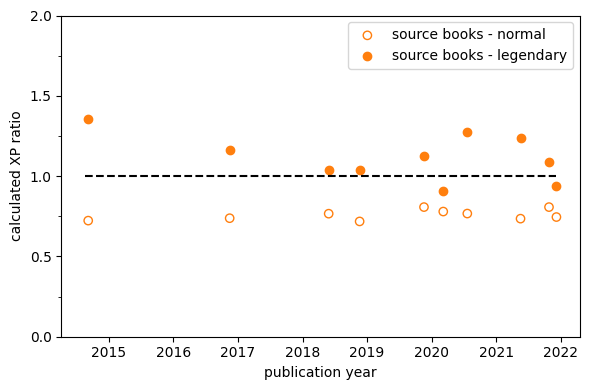

In [46]:
# plot eXP ratio vs time. Split data by book type.
col = 'eXP Ratio'
groupbyCol = 'Date'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
groups = {
    'source books - normal': {
        'Book Type': ['Source'],
        'Legendary': ['N'],
        'Edge Color': colors[1],
        'Face Color': 'none',
        'Marker': 'o'
    },
    'source books - legendary': {
        'Book Type': ['Source'],
        'Legendary': ['L','LL'],
        'Edge Color': colors[1],
        'Face Color': colors[1],
        'Marker': 'o'
    }
}

# summarize the current dataset
df1 = df0[df0['CR'].between(1,30) & df0['Legendary'].isin(['N','L','LL'])]

# plot results
fig = plt.figure(figsize=[6,4], dpi=FDPI, tight_layout=True)
ax = plt.axes()

for g in groups:
    group = groups[g]
    mask = (df1['Book Type'].isin(group['Book Type']) & df1['Legendary'].isin(group['Legendary']))
    dfG = df1[mask].groupby(['Date']).size().to_frame('Total').reset_index()
    dfG['Mean'] = df1[mask].groupby(['Date']).mean().reset_index()[col]
    dfG['Std Dev'] = df1[mask].groupby(['Date']).std().reset_index()[col]
    dfG = dfG.sort_values(by=['Date'])
    dfG = dfG[dfG['Total'].ge(1)]
    ax.scatter(x='Date', y='Mean', data=dfG, label=g, marker=group['Marker'], 
        edgecolors=group['Edge Color'], facecolors=group['Face Color'])

dateLims = [df1['Date'].min(),df1['Date'].max()]
ax.plot(dateLims, [1]*len(dateLims), '--', color='k')
ax.set(xlabel='publication year', ylabel='calculated XP ratio', ylim=[0,2])
ax.legend()

ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

if SAVEFIGS: plt.savefig('exp-ratio-mean-vs-time-source-books-legendary.svg', metadata=METADATA)

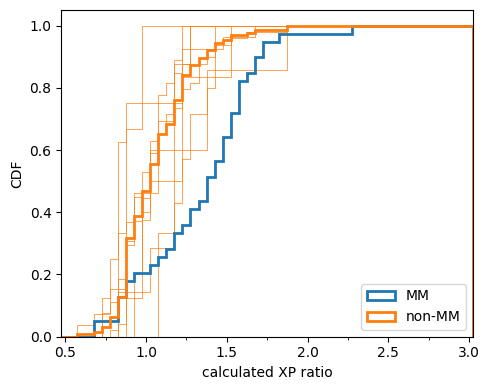

In [47]:
# plot CDF of eXP Ratio for different source books
plotColumn = 'eXP Ratio'
groups = {
    'MM': {'Book': ['MM'], 'color': colors[0]},
    'non-MM': {'Book': ['VGtM','MToF','GGtR','ERftLW','EGtW','MOoT','VRGtR','FToD','SaCoC'], 'color': colors[1]}
}

df1 = df0[df0['CR'].between(1,30) & df0['Book Type'].isin(['Source']) & df0['Legendary'].isin(['L','LL'])]
df1['Book'] = df1['Book'].cat.remove_unused_categories()

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

rMin = 0.5; rMax = 3; rDel = 0.05
rLims = [rMin - rDel/2, rMax + rDel/2]
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()
for b in groups['non-MM']['Book']:
    ax.hist(df1[df1['Book'].isin([b])][plotColumn], rRange, density=True, cumulative=True, histtype='step', 
        linewidth=0.5, edgecolor=groups['non-MM']['color'])

for g in groups:
    ax.hist(df1[df1['Book'].isin(groups[g]['Book'])][plotColumn], rRange, density=True, cumulative=True, histtype='step', label=g, 
        linewidth=2, edgecolor=groups[g]['color'])

ax.set(xlim=rLims, xlabel='calculated XP ratio', ylabel='CDF')
ax.legend(loc='lower right')

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

if SAVEFIGS: plt.savefig('exp-ratio-cdf-mm-vs-source-books.svg', metadata=METADATA)

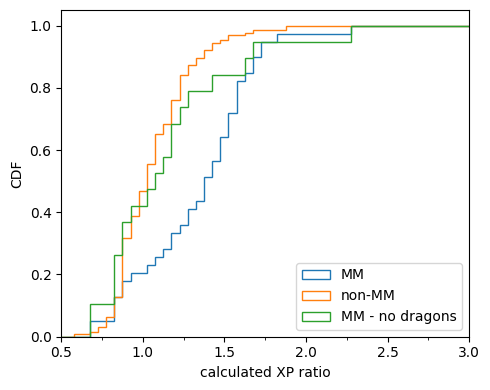

In [48]:
# summarize the current dataset
df1 = df0[df0['CR'].between(1,30) 
    & df0['Book Type'].isin(['Source']) 
    & df0['Legendary'].isin(['L','LL'])]

col = 'eXP Ratio'

groups = {
    'MM': {'Book': ['MM'], 'Exclude Type': []},
    'non-MM': {'Book': ['VGtM','MToF','GGtR','ERftLW','EGtW','MOoT','VRGtR','FToD','SaCoC'], 'Exclude Type': []},
    'MM - no dragons': {'Book': ['MM'], 'Exclude Type': ['dragon']},
}

rMin = 0.5; rMax = 3; rDel = 0.05
rLims = [rMin - rDel/2, rMax + rDel/2]
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()

for g in groups:
    ax.hist(df1[df1['Book'].isin(groups[g]['Book']) & ~df1['Type'].isin(groups[g]['Exclude Type'])]['eXP Ratio'],
        rRange, density=True, cumulative=True, histtype='step', linewidth=1, label=g)

ax.set(xlim=[0.5,3.0], xlabel='calculated XP ratio', ylabel='CDF')
ax.legend(loc='lower right')

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

if SAVEFIGS: plt.savefig('exp-ratio-cdf-mm-vs-source-books-no-dragons.svg', metadata=METADATA)

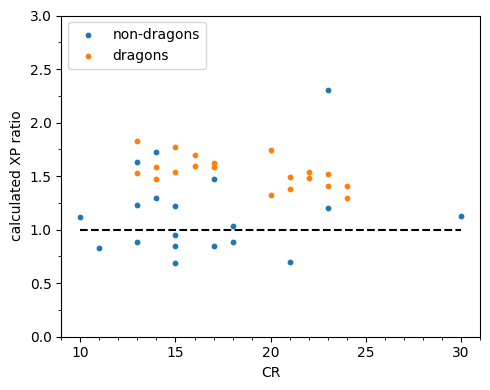

In [49]:
# dragons in the MM vs non-dragons
df1 = df0[df0['Book'].isin(['MM']) & df0['Legendary'].isin(['L','LL'])]
col = 'eXP Ratio'

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()

ax.scatter(x='CR', y='eXP Ratio', s=10, data=df1[~df1['Type'].isin(['dragon'])], label='non-dragons')
ax.scatter(x='CR', y='eXP Ratio', s=10, data=df1[df1['Type'].isin(['dragon'])], label='dragons')

ax.plot([10,30], [1,1], '--', color='k')
ax.set(xlabel='CR', ylabel='calculated XP ratio', ylim=[0,3.0])
ax.legend(loc='upper left')

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

if SAVEFIGS: plt.savefig('exp-ratio-vs-cr-mm-type-dragon.svg', metadata=METADATA)

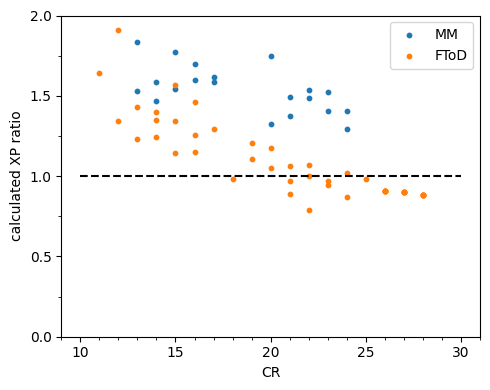

In [50]:
# comparison between dragons published in the MM and those puliblished in FToD
df1 = df0[df0['CR'].between(1,30) & df0['Legendary'].isin(['L','LL']) & df0['Type'].isin(['dragon'])]

books = ['MM','FToD']#,'SaCoC'

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(ylim=[0,2])

for book in books:
    dft = df1[df1['Book'].isin([book])]
    ax.scatter(dft['CR'], dft['eXP Ratio'], label=book, alpha=1.0, s=10)

ax.plot([10, 30], [1,1], '--', color='k')

ax.set(xlabel='CR', ylabel='calculated XP ratio')
ax.legend(loc='upper right')
#ax.grid(which='major', axis='both', alpha=0.4)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

if SAVEFIGS: plt.savefig('exp-ratio-vs-cr-mm-ftod-type-dragon.svg', metadata=METADATA)

In [51]:
df1 = df0[df0['CR'].between(1,30) & df0['Legendary'].isin(['L','LL']) & df0['Type'].isin(['dragon'])]
dfM = df1[df1['Book'].isin(['MM'])].mean()['eXP Ratio']
dfF = df1[df1['Book'].isin(['FToD'])].mean()['eXP Ratio']
dfF

<ipython-input-51-414a1a940976>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  dfM = df1[df1['Book'].isin(['MM'])].mean()['eXP Ratio']
<ipython-input-51-414a1a940976>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  dfF = df1[df1['Book'].isin(['FToD'])].mean()['eXP Ratio']


1.0934828804047816

No handles with labels found to put in legend.


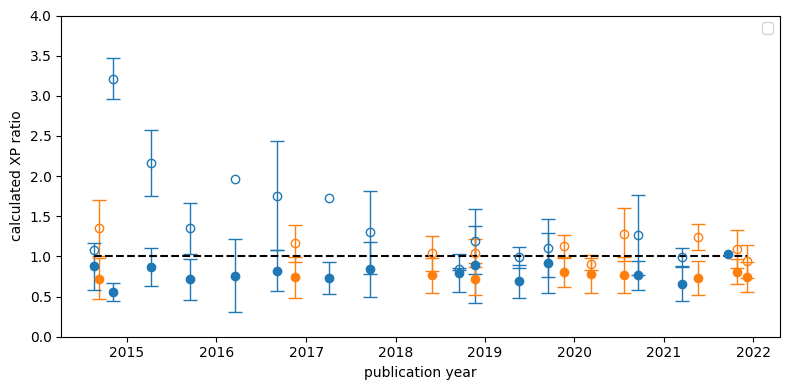

In [52]:
# plot eXP ratio vs time. Split data by book type.
col = 'eXP Ratio'
groupbyCol = 'Date'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
groups = {
    'adventure books - normal': {
        'Book Type': ['Adventure'],
        'Legendary': ['N'],
        'Edge Color': colors[0],
        'Face Color': colors[0],
        'Marker': 'o'
    },
    'adventure books - legendary': {
        'Book Type': ['Adventure'],
        'Legendary': ['L','LL'],
        'Edge Color': colors[0],
        'Face Color': 'none',
        'Marker': 'o'
    },
    'source books - normal': {
        'Book Type': ['Source'],
        'Legendary': ['N'],
        'Edge Color': colors[1],
        'Face Color': colors[1],
        'Marker': 'o'
    },
    'source books - legendary': {
        'Book Type': ['Source'],
        'Legendary': ['L','LL'],
        'Edge Color': colors[1],
        'Face Color': 'none',
        'Marker': 'o'
    }
}

# summarize the current dataset
df1 = df0[df0['CR'].between(1,30) & df0['Legendary'].isin(['N','L','LL'])]

# plot results
fig = plt.figure(figsize=[8,4], dpi=FDPI, tight_layout=True)
ax = plt.axes()

for g in groups:
    group = groups[g]
    mask = (df1['Book Type'].isin(group['Book Type']) & df1['Legendary'].isin(group['Legendary']))
    dfG = df1[mask].groupby(['Date']).size().to_frame('Total').reset_index()
    dfG['Mean'] = df1[mask].groupby(['Date']).mean().reset_index()[col]
    dfG['Std Dev'] = df1[mask].groupby(['Date']).std().reset_index()[col]
    dfG = dfG.sort_values(by=['Date'])
    dfG = dfG[dfG['Total'].ge(1)]
    ax.errorbar(x=dfG['Date'], y=dfG['Mean'], yerr=dfG['Std Dev'], 
        markeredgecolor=group['Edge Color'], markerfacecolor=group['Face Color'],
        fmt='o', elinewidth=1, capsize=5, ecolor=group['Edge Color'])

dateLims = [df1['Date'].min(),df1['Date'].max()]
ax.plot(dateLims, [1]*len(dateLims), '--', color='k')
ax.set(xlabel='publication year', ylabel='calculated XP ratio', ylim=[0,4])
ax.legend()

#if SAVEFIGS: plt.savefig('exp-ratio-mean-vs-time-by-book-type-and-legendary.svg', metadata=METADATA)

No handles with labels found to put in legend.


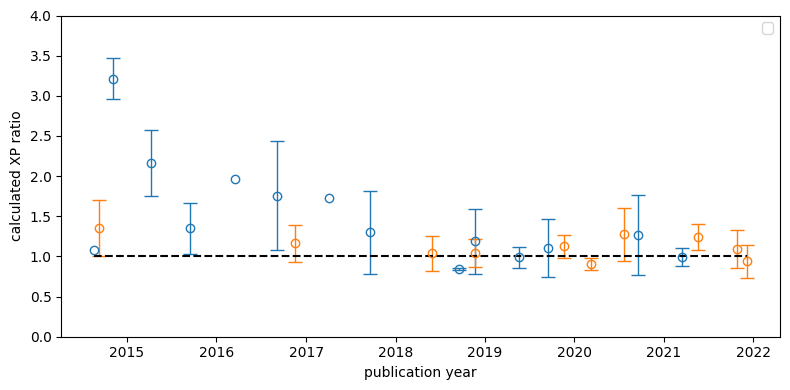

In [53]:
# plot eXP ratio vs time. Legendary monsters only.
col = 'eXP Ratio'
groupbyCol = 'Date'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
groups = {
    'adventure books - legendary': {
        'Book Type': ['Adventure'],
        'Legendary': ['L','LL'],
        'Edge Color': colors[0],
        'Face Color': 'none',
        'Marker': 'o'
    },
    'source books - legendary': {
        'Book Type': ['Source'],
        'Legendary': ['L','LL'],
        'Edge Color': colors[1],
        'Face Color': 'none',
        'Marker': 'o'
    }
}

# summarize the current dataset
df1 = df0[df0['CR'].between(1,30) & df0['Legendary'].isin(['N','L','LL'])]

# plot results
fig = plt.figure(figsize=[8,4], dpi=FDPI, tight_layout=True)
ax = plt.axes()

for g in groups:
    group = groups[g]
    mask = (df1['Book Type'].isin(group['Book Type']) & df1['Legendary'].isin(group['Legendary']))
    dfG = df1[mask].groupby(['Date']).size().to_frame('Total').reset_index()
    dfG['Mean'] = df1[mask].groupby(['Date']).mean().reset_index()[col]
    dfG['Std Dev'] = df1[mask].groupby(['Date']).std().reset_index()[col]
    dfG = dfG.sort_values(by=['Date'])
    dfG = dfG[dfG['Total'].ge(1)]
    ax.errorbar(x=dfG['Date'], y=dfG['Mean'], yerr=dfG['Std Dev'], 
        markeredgecolor=group['Edge Color'], markerfacecolor=group['Face Color'],
        fmt='o', elinewidth=1, capsize=5, ecolor=group['Edge Color'])

dateLims = [df1['Date'].min(),df1['Date'].max()]
ax.plot(dateLims, [1]*len(dateLims), '--', color='k')
ax.set(xlabel='publication year', ylabel='calculated XP ratio', ylim=[0,4])
ax.legend()